In [52]:
import tensorflow as tf
import pandas as pd
import typing
import numpy as np
import matplotlib.pyplot as plt
from typing import Union, Tuple, List
from sklearn.model_selection import train_test_split
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping

In [53]:
class FD_Network(tf.keras.Model):
    """
    network to train a model approximating the Weidmann Model on given data
    """
    def __init__(self):
        """
        initialize the network, very simple feed forward network with 3 parameter outputs
        """
        super(FD_Network, self).__init__()
        self.hidden_layer = tf.keras.layers.Dense(10)
        # output layers producing the 3 parameters of the FD
        self.desired_speed = tf.keras.layers.Dense(1)
        self.pedestrian_size = tf.keras.layers.Dense(1)
        self.time_gap = tf.keras.layers.Dense(1)
        self.FD_model_parameters = {'t': [], 'l': [], 'v0': []}
        self.mse = -1

    def call(self, mean_spacing):
        """
        execute the feedforward, create the fd function from the parameters, return the predicted speed
        :param mean_spacing: only input of the net
        :return: predicted speed
        """
        x = self.hidden_layer(mean_spacing)
        x = tf.keras.activations.sigmoid(x)
        v0 = self.desired_speed(x)
        v0 = tf.keras.activations.softplus(v0)  # if bidirectional not needed!
        l = self.pedestrian_size(x)
        l = tf.keras.activations.softplus(l)
        t = self.time_gap(x)
        t = tf.keras.activations.softplus(t)
        self.FD_model_parameters['t'].append(tf.math.reduce_mean(t, 0))
        self.FD_model_parameters['l'].append(tf.math.reduce_mean(l, 0))
        self.FD_model_parameters['v0'].append(tf.math.reduce_mean(v0, 0))
        return v0 * (1 - tf.exp((l - mean_spacing) / (v0 * t)))

In [54]:
def read_dataset(path: str) -> (np.ndarray, np.ndarray):
    """
    Read the complete dataset to be fed to the NN
    :param path: path of the pickle file containing the dataset
    :param fd_training: if True keep also k nearest neighbour for input, False leaves only mean spacing for FDNetwork
    :return: data and targets in the form of 2 numpy ndarrays
    """
    #col_names = ["timestep", "ID", "X", "Y", "speed", "mean_spacing"]
    dataset = pd.read_csv(path, sep=" ", header=None)
    dataset.columns=dataset.iloc[0]
    dataset = dataset[1:]
    targets = dataset[['speed']].to_numpy()
    mean_spacing = dataset[['mean_spacing']].to_numpy()
   
    return mean_spacing.astype(float), targets.astype(float)

In [55]:
def plot_fd_and_original(data_path: str, plot_title: str = "", fd_epochs: int = 50, test_data=None, test_targets=None, run_eagerly=False, verbose=1):
    """
    Plots the observed speeds and the ones predicted by the FD model, depending on the mean spacing
    :param data_path: path of the file containing the data
    :param plot_title: title of the plot
    :param fd_epochs: number of epochs of training for the FD
    :param test_data: test data
    :param test_targets: targets for the test data
    :param run_eagerly: parameter to pass at tensorflow's fit method (used to access some of the model's outputs)
    :param verbose: level of verbosity to be passed at tensorflow's fit method
    :return fd trained model
    """
    fd_data, fd_targets = read_dataset(data_path)

    # to stop the computation when model is at its cap
    callback = EarlyStopping(monitor='loss', patience=10)  # default on val_loss

    # train the FD model
    model = FD_Network()
    model.compile(optimizer='adam', loss='mse', run_eagerly=run_eagerly)
    model.fit(x=fd_data, y=fd_targets, epochs=fd_epochs, verbose=verbose, callbacks=[callback])

    # generate the FD speeds with prediction
    stop = np.max(fd_data) * 1.5
    mean_spacings = np.expand_dims(np.linspace(start=0.5, stop=stop, num=1000), axis=1)
    if test_data is not None:
        mean_spacings = test_data
    fd_speeds = model.predict(x=mean_spacings)
    if test_targets is not None:
        model.mse = np.mean((fd_speeds - test_targets) ** 2)

    # plot the FD prediction over the observations
    plt.plot(mean_spacings, fd_speeds, c='orange')  # fd model data
    plt.scatter(fd_data, fd_targets, s=1)  # original data
    plt.xlabel("Mean spacing")
    plt.ylabel("Speed")
    plt.title(plot_title)
    plt.show()
    return model

Epoch 1/50
216/216 [==============================] - 1s 1ms/step - loss: 0.1888
Epoch 2/50
216/216 [==============================] - 0s 1ms/step - loss: 0.1686
Epoch 3/50
216/216 [==============================] - 0s 1ms/step - loss: 0.1683
Epoch 4/50
216/216 [==============================] - 0s 1ms/step - loss: 0.1681
Epoch 5/50
216/216 [==============================] - 0s 1ms/step - loss: 0.1680
Epoch 6/50
216/216 [==============================] - 0s 1ms/step - loss: 0.1680
Epoch 7/50
216/216 [==============================] - 0s 1ms/step - loss: 0.1678
Epoch 8/50
216/216 [==============================] - 0s 1ms/step - loss: 0.1677
Epoch 9/50
216/216 [==============================] - 0s 1ms/step - loss: 0.1676
Epoch 10/50
216/216 [==============================] - 0s 1ms/step - loss: 0.1675
Epoch 11/50
216/216 [==============================] - 0s 1ms/step - loss: 0.1675
Epoch 12/50
216/216 [==============================] - 0s 1ms/step - loss: 0.1674
Epoch 13/50
216/216 [====

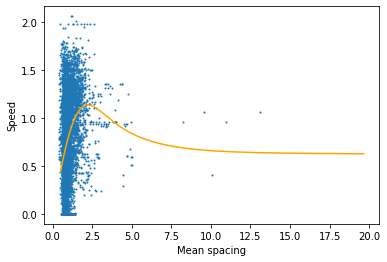

In [56]:
path = "corridor_both_directions_revised2_dataset.txt"
model = plot_fd_and_original(path)
model

Epoch 1/50
276/276 [==============================] - 1s 1ms/step - loss: 0.1420
Epoch 2/50
276/276 [==============================] - 0s 1ms/step - loss: 0.1334
Epoch 3/50
276/276 [==============================] - 0s 1ms/step - loss: 0.1331
Epoch 4/50
276/276 [==============================] - 0s 1ms/step - loss: 0.1330
Epoch 5/50
276/276 [==============================] - 0s 1ms/step - loss: 0.1330
Epoch 6/50
276/276 [==============================] - 0s 1ms/step - loss: 0.1329
Epoch 7/50
276/276 [==============================] - 0s 1ms/step - loss: 0.1328
Epoch 8/50
276/276 [==============================] - 0s 1ms/step - loss: 0.1328
Epoch 9/50
276/276 [==============================] - 0s 1ms/step - loss: 0.1328
Epoch 10/50
276/276 [==============================] - 0s 1ms/step - loss: 0.1326
Epoch 11/50
276/276 [==============================] - 0s 1ms/step - loss: 0.1327
Epoch 12/50
276/276 [==============================] - 0s 1ms/step - loss: 0.1326
Epoch 13/50
276/276 [====

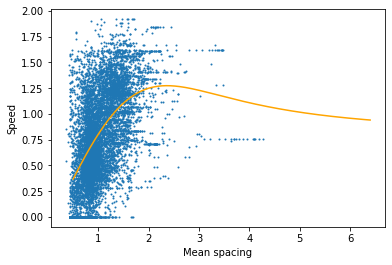

In [57]:
path2 ='left_turn_revised2_dataset.txt'
model2 = plot_fd_and_original(path2)
model2

Epoch 1/50
276/276 [==============================] - 1s 1ms/step - loss: 0.6228
Epoch 2/50
276/276 [==============================] - 0s 1ms/step - loss: 0.2259
Epoch 3/50
276/276 [==============================] - 0s 1ms/step - loss: 0.1368
Epoch 4/50
276/276 [==============================] - 0s 1ms/step - loss: 0.1350
Epoch 5/50
276/276 [==============================] - 0s 1ms/step - loss: 0.1345
Epoch 6/50
276/276 [==============================] - 0s 1ms/step - loss: 0.1342
Epoch 7/50
276/276 [==============================] - 0s 1ms/step - loss: 0.1340
Epoch 8/50
276/276 [==============================] - 0s 1ms/step - loss: 0.1339
Epoch 9/50
276/276 [==============================] - 0s 1ms/step - loss: 0.1337
Epoch 10/50
276/276 [==============================] - 0s 1ms/step - loss: 0.1337
Epoch 11/50
276/276 [==============================] - 0s 1ms/step - loss: 0.1335
Epoch 12/50
276/276 [==============================] - 0s 1ms/step - loss: 0.1335
Epoch 13/50
276/276 [====

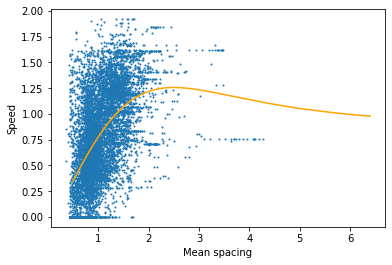

In [58]:
path3 = 'supermarket_revised2_dataset.txt'
model3 = plot_fd_and_original(path2)
model3
